In [1]:
import numpy as np 
import pandas as pd
from datetime import datetime

# RFV

**RFV** significa recência, frequência, valor e é utilizado para segmentação de clientes baseado no comportamento de compras dos clientes e agrupa eles em clusters parecidos. Utilizando esse tipo de agrupamento podemos realizar ações de marketing e CRM melhores direcionadas, ajudando assim na personalização do conteúdo e até a retenção de clientes.

Para cada cliente é preciso calcular cada uma das componentes abaixo:

- Recência (R): Quantidade de dias desde a última compra.
- Frequência (F): Quantidade total de compras no período.
- Valor (V): Total de dinheiro gasto nas compras do período.

E é isso que iremos fazer abaixo.

In [2]:
df_compras = pd.read_csv('./data/dados_input 1.csv',
                         infer_datetime_format=True,
                         parse_dates=['DiaCompra'])
df_compras.head()

C:\Users\gfsil\AppData\Local\Temp\ipykernel_16112\1011687513.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_compras = pd.read_csv('./data/dados_input 1.csv',


,ID_cliente,CodigoCompra,DiaCompra,ValorTotal
0,12747,537215,2020-12-05,358.56
1,12747,538537,2020-12-13,347.71
2,12747,541677,2021-01-20,303.04
3,12747,545321,2021-03-01,310.78
4,12747,551992,2021-05-05,442.96


In [3]:
df_compras.shape

(16127, 4)

In [4]:
df_compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16127 entries, 0 to 16126
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID_cliente    16127 non-null  int64         
 1   CodigoCompra  16127 non-null  int64         
 2   DiaCompra     16127 non-null  datetime64[ns]
 3   ValorTotal    16127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 504.1 KB


In [5]:
df_compras['DiaCompra'].min()

Timestamp('2020-12-01 00:00:00')

In [6]:
df_compras['DiaCompra'].max()

Timestamp('2021-12-09 00:00:00')

In [7]:
dia_atual = datetime(2021, 12, 9)
print(dia_atual)

2021-12-09 00:00:00


## Recência

**Quantos dias faz que o cliente fez a sua última compra?**

In [8]:
#group by customers and check last date of purshace
df_recencia = df_compras.groupby(by='ID_cliente',
                                 as_index=False)['DiaCompra'].max()
df_recencia.columns = ['ID_cliente', 'DiaUltimaCompra']
df_recencia.head()

,ID_cliente,DiaUltimaCompra
0,12747,2021-12-07
1,12748,2021-12-09
2,12749,2021-12-06
3,12820,2021-12-06
4,12821,2021-05-09


In [9]:
df_recencia['Recencia'] = df_recencia['DiaUltimaCompra'].apply(
    lambda x: (dia_atual - x).days)
df_recencia.head()

,ID_cliente,DiaUltimaCompra,Recencia
0,12747,2021-12-07,2
1,12748,2021-12-09,0
2,12749,2021-12-06,3
3,12820,2021-12-06,3
4,12821,2021-05-09,214


In [10]:
df_compras['DiaCompra'].max()

Timestamp('2021-12-09 00:00:00')

In [11]:
dia_atual = datetime(2021,12,9)
print(dia_atual)

2021-12-09 00:00:00


In [12]:
df_recencia.drop('DiaUltimaCompra', axis=1, inplace=True)

## Frequência

**Quantas vezes cada cliente comprou com a gente?**

In [13]:
df_compras.head()

,ID_cliente,CodigoCompra,DiaCompra,ValorTotal
0,12747,537215,2020-12-05,358.56
1,12747,538537,2020-12-13,347.71
2,12747,541677,2021-01-20,303.04
3,12747,545321,2021-03-01,310.78
4,12747,551992,2021-05-05,442.96


In [14]:
df_frequencia = df_compras[['ID_cliente', 'CodigoCompra'
                            ]].groupby('ID_cliente').count().reset_index()
df_frequencia.columns = ['ID_cliente', 'Frequencia']
df_frequencia.head()

,ID_cliente,Frequencia
0,12747,11
1,12748,178
2,12749,5
3,12820,4
4,12821,1


## Valor

**Quanto que cada cliente gastou no periodo?**

In [15]:
df_valor = df_compras[['ID_cliente', 'ValorTotal'
                       ]].groupby('ID_cliente').sum().reset_index()
df_valor.columns = ['ID_cliente', 'Valor']
df_valor.head()

,ID_cliente,Valor
0,12747,4196.01
1,12748,31533.04
2,12749,4090.88
3,12820,942.34
4,12821,92.72


## Criando a tabela RFV

In [16]:
df_RF = df_recencia.merge(df_frequencia, on='ID_cliente')
df_RF.head()

,ID_cliente,Recencia,Frequencia
0,12747,2,11
1,12748,0,178
2,12749,3,5
3,12820,3,4
4,12821,214,1


In [17]:
df_RFV = df_RF.merge(df_valor, on='ID_cliente')
df_RFV.set_index('ID_cliente', inplace=True)
df_RFV.head()

,Recencia,Frequencia,Valor
ID_cliente,,,
12747,2,11,4196.01
12748,0,178,31533.04
12749,3,5,4090.88
12820,3,4,942.34
12821,214,1,92.72


## Segmentação de clientes utilizando o RFV

Um jeito de segmentar os clientes é criando quartis para cada componente do RFV, sendo que o melhor quartil é chamado de 'A', o segundo melhor quartil de 'B', o terceiro melhor de 'C' e o pior de 'D'. O melhor e o pior depende da componente. Po exemplo, quanto menor a recência melhor é o cliente (pois ele comprou com a gente tem pouco tempo) logo o menor quartil seria classificado como 'A', já pra componente frêquencia a lógica se inverte, ou seja, quanto maior a frêquencia do cliente comprar com a gente, melhor ele/a é, logo, o maior quartil recebe a letra 'A'.

Se a gente tiver interessado em mais ou menos classes, basta a gente aumentar ou diminuir o número de quantils pra cada componente.

### Quartis para o RFV

In [18]:
quartis = df_RFV.quantile(q=[0.25, 0.5, 0.75])
quartis

,Recencia,Frequencia,Valor
0.25,17.0,1.0,299.705
0.50,50.0,2.0,643.555
0.75,143.0,5.0,1533.600


In [19]:
quartis.to_dict()

{'Recencia': {0.25: 17.0, 0.5: 50.0, 0.75: 143.0},
 'Frequencia': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Valor': {0.25: 299.70500000000004, 0.5: 643.555, 0.75: 1533.6}}

### Criando os segmentos

In [20]:
def recencia_class(x, r, q_dict):
    """Classifica como melhor o menor quartil 
       x = valor da linha,
       r = recencia,
       q_dict = quartil dicionario   
    """
    if x <= q_dict[r][0.25]:
        return 'A'
    elif x <= q_dict[r][0.50]:
        return 'B'
    elif x <= q_dict[r][0.75]:
        return 'C'
    else:
        return 'D'


def freq_val_class(x, fv, q_dict):
    """Classifica como melhor o maior quartil 
       x = valor da linha,
       fv = frequencia ou valor,
       q_dict = quartil dicionario   
    """
    if x <= q_dict[fv][0.25]:
        return 'D'
    elif x <= q_dict[fv][0.50]:
        return 'C'
    elif x <= q_dict[fv][0.75]:
        return 'B'
    else:
        return 'A'

In [21]:
df_RFV['R_quartil'] = df_RFV['Recencia'].apply(recencia_class,
                                                args=('Recencia', quartis))
df_RFV['F_quartil'] = df_RFV['Frequencia'].apply(freq_val_class,
                                                  args=('Frequencia', quartis))
df_RFV['V_quartil'] = df_RFV['Valor'].apply(freq_val_class,
                                             args=('Valor', quartis))

In [22]:
df_RFV.head()

,Recencia,Frequencia,Valor,R_quartil,F_quartil,V_quartil
ID_cliente,,,,,,
12747,2,11,4196.01,A,A,A
12748,0,178,31533.04,A,A,A
12749,3,5,4090.88,A,B,A
12820,3,4,942.34,A,B,B
12821,214,1,92.72,D,D,D


In [23]:
df_RFV['RFV_Score'] = (df_RFV.R_quartil + df_RFV.F_quartil +
                       df_RFV.V_quartil)
df_RFV.head()

,Recencia,Frequencia,Valor,R_quartil,F_quartil,V_quartil,RFV_Score
ID_cliente,,,,,,,
12747,2,11,4196.01,A,A,A,AAA
12748,0,178,31533.04,A,A,A,AAA
12749,3,5,4090.88,A,B,A,ABA
12820,3,4,942.34,A,B,B,ABB
12821,214,1,92.72,D,D,D,DDD


In [24]:
df_RFV['RFV_Score'].value_counts()

RFV_Score
AAA    417
DDD    402
DDC    212
BBB    187
CDD    186
BAA    166
ABB    153
CDC    140
BDD    139
CBB    133
CBA     96
ABA     87
DCC     87
BDC     85
CCB     83
BBA     81
BCC     79
CCC     79
ACC     65
BCB     65
CAA     63
CBC     60
DCB     57
DCD     54
ADD     53
BBC     53
AAB     47
ACB     46
CDB     43
BCD     43
ABC     42
DBB     41
DBC     37
DDB     36
CCD     35
BAB     35
ADC     32
ACD     32
CAB     23
BDB     20
DAA     14
DBA     13
BCA     11
CCA     10
CBD     10
DBD      9
ABD      7
DCA      6
CDA      6
BBD      5
DDA      3
ADB      3
DAB      3
AAC      3
ACA      2
BDA      1
CAC      1
AAD      1
Name: count, dtype: int64

In [25]:
quartis

,Recencia,Frequencia,Valor
0.25,17.0,1.0,299.705
0.50,50.0,2.0,643.555
0.75,143.0,5.0,1533.600


In [26]:
df_RFV[df_RFV['RFV_Score'] == 'AAA'].sort_values('Valor',
                                                 ascending=False).head()

,Recencia,Frequencia,Valor,R_quartil,F_quartil,V_quartil,RFV_Score
ID_cliente,,,,,,,
15311,0,87,49024.04,A,A,A,AAA
13089,2,93,48391.47,A,A,A,AAA
17841,1,115,40940.46,A,A,A,AAA
13694,3,40,37030.67,A,A,A,AAA
16013,3,45,32734.40,A,A,A,AAA


### Ações de marketing/CRM

In [27]:
dict_acoes = {
    'AAA':
    'Enviar cupons de desconto, Pedir para indicar nosso produto pra algum amigo, Ao lançar um novo produto enviar amostras grátis pra esses.',
    'DDD':
    'Churn! clientes que gastaram bem pouco e fizeram poucas compras, fazer nada',
    'DAA':
    'Churn! clientes que gastaram bastante e fizeram muitas compras, enviar cupons de desconto para tentar recuperar',
    'CAA':
    'Churn! clientes que gastaram bastante e fizeram muitas compras, enviar cupons de desconto para tentar recuperar'
}

In [28]:
df_RFV['acoes de marketing/crm'] = df_RFV['RFV_Score'].map(dict_acoes)
df_RFV.head()

,Recencia,Frequencia,Valor,R_quartil,F_quartil,V_quartil,RFV_Score,acoes de marketing/crm
ID_cliente,,,,,,,,
12747,2,11,4196.01,A,A,A,AAA,"Enviar cupons de desconto, Pedir para indicar ..."
12748,0,178,31533.04,A,A,A,AAA,"Enviar cupons de desconto, Pedir para indicar ..."
12749,3,5,4090.88,A,B,A,ABA,NaN
12820,3,4,942.34,A,B,B,ABB,NaN
12821,214,1,92.72,D,D,D,DDD,Churn! clientes que gastaram bem pouco e fizer...


In [29]:
df_RFV.to_excel('./output/RFV.xlsx')

# k-means

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

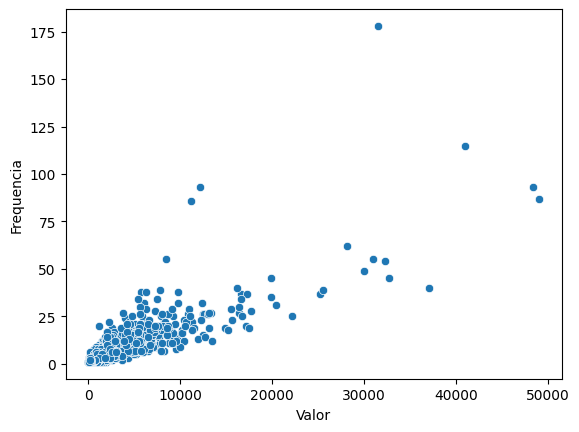

In [31]:
sns.scatterplot(
    x='Valor',
    y='Frequencia',
    data=df_RFV
)
plt.show()

In [32]:
dict_clusters = {
    'Enviar cupons de desconto, Pedir para indicar nosso produto pra algum amigo, Ao lançar um novo produto enviar amostras grátis pra esses.':
    1,
    'Churn! clientes que gastaram bem pouco e fizeram poucas compras, fazer nada':
    2,
    'Churn! clientes que gastaram bastante e fizeram muitas compras, enviar cupons de desconto para tentar recuperar':
    3,
    'Churn! clientes que gastaram bastante e fizeram muitas compras, enviar cupons de desconto para tentar recuperar':
    4,
    np.nan: 5
}
df_RFV['clusters'] = df_RFV['acoes de marketing/crm'].map(dict_clusters)
df_RFV.head()

,Recencia,Frequencia,Valor,R_quartil,F_quartil,V_quartil,RFV_Score,acoes de marketing/crm,clusters
ID_cliente,,,,,,,,,
12747,2,11,4196.01,A,A,A,AAA,"Enviar cupons de desconto, Pedir para indicar ...",1
12748,0,178,31533.04,A,A,A,AAA,"Enviar cupons de desconto, Pedir para indicar ...",1
12749,3,5,4090.88,A,B,A,ABA,NaN,5
12820,3,4,942.34,A,B,B,ABB,NaN,5
12821,214,1,92.72,D,D,D,DDD,Churn! clientes que gastaram bem pouco e fizer...,2


In [33]:
X_train = df_RFV[df_RFV.columns[:3]]
y_train = df_RFV[[df_RFV.columns[-1]]]
print(X_train.shape)
print(y_train.shape)

(3902, 3)
(3902, 1)


In [34]:
k = len(dict_clusters)
k

4

In [35]:
km = KMeans(n_clusters=k)
km = km.fit(X_train)

In [36]:
km.labels_

array([3, 2, 3, ..., 0, 0, 0])

In [37]:
df_RFV['k-means'] = km.labels_
df_RFV.head()

,Recencia,Frequencia,Valor,R_quartil,F_quartil,V_quartil,RFV_Score,acoes de marketing/crm,clusters,k-means
ID_cliente,,,,,,,,,,
12747,2,11,4196.01,A,A,A,AAA,"Enviar cupons de desconto, Pedir para indicar ...",1,3
12748,0,178,31533.04,A,A,A,AAA,"Enviar cupons de desconto, Pedir para indicar ...",1,2
12749,3,5,4090.88,A,B,A,ABA,NaN,5,3
12820,3,4,942.34,A,B,B,ABB,NaN,5,0
12821,214,1,92.72,D,D,D,DDD,Churn! clientes que gastaram bem pouco e fizer...,2,0


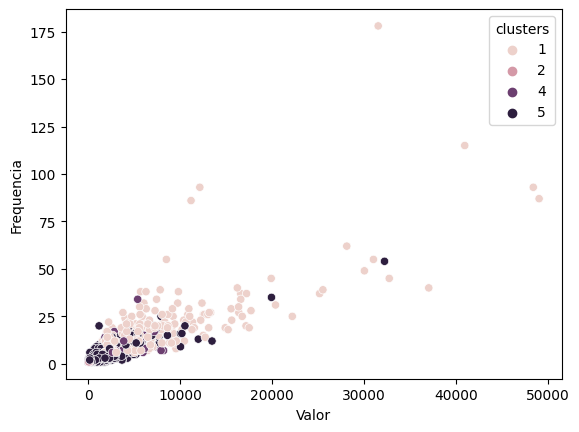

In [39]:
sns.scatterplot(
    x='Valor',
    y='Frequencia',
    hue="clusters",
    data=df_RFV
)
plt.show()

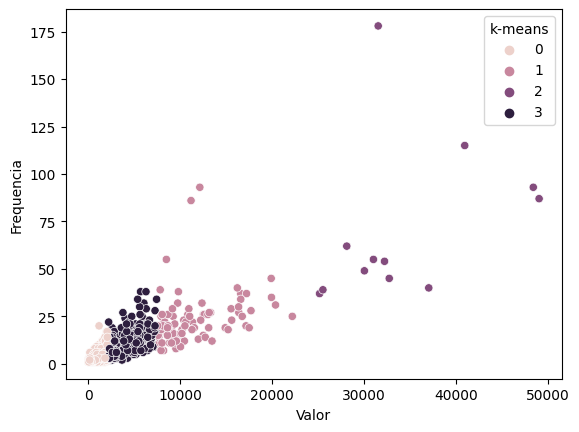

In [40]:
sns.scatterplot(
    x='Valor',
    y='Frequencia',
    hue="k-means",
    data=df_RFV
)
plt.show()